In [ ]:
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".4"

import abtem
import ase
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from pathlib import Path
import sys
# add parent folder (and common src folder) to sys.path so imports can be resolved
parent = Path.cwd().parent
candidates = [parent, parent / "src"]
for p in candidates:
    if p.exists() and str(p) not in sys.path:
        sys.path.insert(0, str(p))

from wide_angle_propagation import (
    get_abtem_transmit,
    energy2wavelength,
    electron_refractive_index,
    wpm_step_adaptive,
    wpm_step
)

from tqdm import trange

abtem.config.set({"device": "cpu"})
abtem.config.set({"precision": "float64"})
jax.config.update("jax_enable_x64", True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_wpm_diagnostics(n_map, w, idx_L, n_refs):
    """
    Visualizes WPM binning, weights, and the resulting approximation error.
    """
    # Convert JAX arrays to Numpy
    n_map_np = np.array(n_map)
    w_np = np.array(w)
    idx_L_np = np.array(idx_L)
    n_refs_np = np.array(n_refs)

    # --- Reconstruct the 'Effective' Refractive Index ---
    # We use the same logic as the wave mixing: n_fit = (1-w)*n_L + w*n_R
    # idx_R is simply idx_L + 1
    idx_R_np = idx_L_np + 1
    
    # Handle edge case: if idx_R exceeds bounds (though code clips it, good to be safe)
    idx_R_np = np.clip(idx_R_np, 0, len(n_refs_np) - 1)

    n_L = n_refs_np[idx_L_np]
    n_R = n_refs_np[idx_R_np]
    
    # The effective refractive index the wave "sees"
    n_fit = (1 - w_np) * n_L + w_np * n_R
    
    # Calculate Error
    error_map = n_map_np - n_fit

    # --- Plotting ---
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 3)

    # 1. Discrete Bins (The Staircase)
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(n_L, cmap='viridis')
    ax1.set_title("Bin Lower Bound ($n_L$)\n(Discretized Map)")
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax1)

    # 2. Weights (The Smooth Mask)
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(w_np, cmap='coolwarm', vmin=0, vmax=1)
    ax2.set_title("Interpolation Weights ($w$)\n(0.0 = Left Bin, 1.0 = Right Bin)")
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax2)

    # 3. Bin Spacing Strategy & Histogram
    ax3 = fig.add_subplot(gs[0, 2])
    # Histogram of the true refractive index distribution
    ax3.hist(n_map_np.flatten(), bins=100, color='gray', alpha=0.5, log=True, label='True Dist.')
    # Overlay bin centers
    for ref in n_refs_np:
        ax3.axvline(ref, color='r', linestyle='-', linewidth=0.5, alpha=0.3)
    # Dummy plot for legend
    ax3.plot([], [], 'r-', linewidth=0.5, label='Bin Centers')
    
    ax3.set_xlabel("Refractive Index")
    ax3.set_ylabel("Count (Log Scale)")
    ax3.set_title("Refractive Index Dist. & Bins")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Error Map (Spatial)
    ax4 = fig.add_subplot(gs[1, 0])
    # Use a diverging colormap centered on 0 to see + vs - errors
    limit = np.max(np.abs(error_map)) if np.max(np.abs(error_map)) > 0 else 1e-5
    im4 = ax4.imshow(error_map, cmap='seismic', vmin=-limit, vmax=limit)
    ax4.set_title("Approximation Error Map\n($n_{true} - n_{fit}$)")
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im4, cax=cax4, format='%.1e')

    # 5. Error Histogram (Statistical) -- show percentage error
    ax5 = fig.add_subplot(gs[1, 1])
    # avoid division by zero: use n_map_np where nonzero, else fall back to small value
    denom = np.where(n_map_np == 0, 1e-12, n_map_np)
    error_pct = 100.0 * (error_map / denom)
    ax5.hist(error_pct.flatten(), bins=100, color='k', log=True)
    ax5.set_title("Error Histogram (Log Scale)")
    ax5.set_xlabel("Refractive Index Error (%)")
    ax5.grid(True, alpha=0.3)

    # 6. 1D Cross-section Comparison
    # Take a slice through the center to see the "fit" vs "original" clearly
    ax6 = fig.add_subplot(gs[1, 2])
    mid_y = n_map_np.shape[0] // 2
    ax6.plot(n_map_np[mid_y, :], 'k-', lw=2, alpha=0.6, label='Original $n_{map}$')
    ax6.plot(n_fit[mid_y, :], 'r--', lw=1, label='Fit $n_{fit}$')
    ax6.set_title(f"1D Cross-Section (Y={mid_y})")
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

In [3]:
atoms = ase.build.mx2(vacuum=0.8)
atoms.set_cell(atoms.cell * np.asarray([1, 1, 4]), scale_atoms=True)
atoms = abtem.orthogonalize_cell(atoms)
atoms *= (3, 2, 1)  # this sets our horizontal extent, and by consequence our final diffraction pattern size

In [4]:
base_slice_thickness = 0.05

potential = abtem.Potential(
    atoms,
    gpts=100,
    projection='infinite',
)

(<Figure size 1000x400 with 2 Axes>,
 <Axes: title={'center': 'Top view'}, xlabel='x [Å]', ylabel='z [Å]'>)

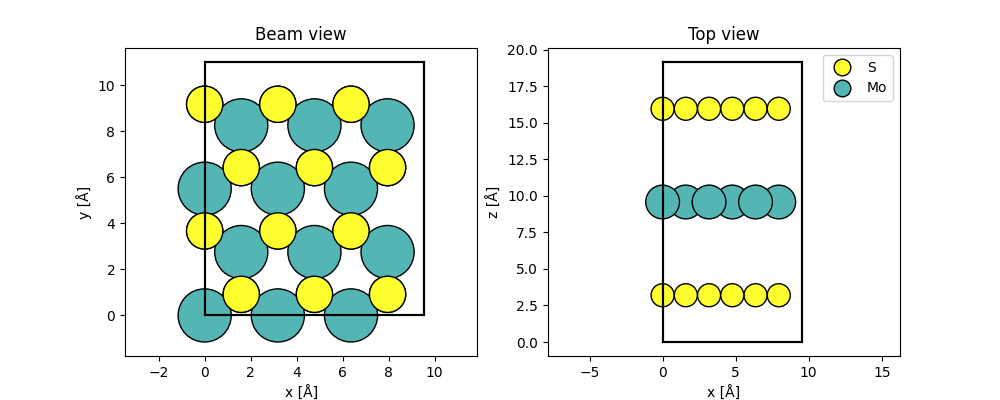

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Top view", legend=True)

In [6]:
energy = 200e3
transmit = get_abtem_transmit(potential, energy)


(1, 100, 100)


Text(0.5, 1.0, 'Slice 0')

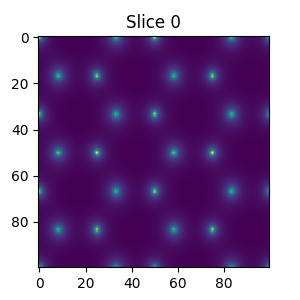

In [7]:
potential_array = potential.build(lazy=False).array.sum(axis=0)[np.newaxis, :, :]  # sum over slices to get projected potential
print(potential_array.shape)
fig, ax = plt.subplots(figsize=(3, 3))
vmin = potential_array.min()
vmax = potential_array.max()

ax.imshow(potential_array[0], vmin=vmin, vmax=vmax)
ax.set_title(f"Slice {0}")

In [8]:
wavelength = energy2wavelength(energy)
semiangle_cutoff = 100
defocus = 2.5
astigmatism = 0.,
astigmatism_angle = 0.,

probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
)
probe.grid.match(potential)
probe_array = probe.build(lazy=False).array

In [9]:
def simulate_pattern_wpm_adaptive(potential, probe, dz, energy, ps):
    wavefront = probe
    wavefronts = []
    weights = []
    indices = []
    n_bin = []
    n_map = []
    for i in trange(potential.shape[0], desc="WPM slices"):
        n = electron_refractive_index(potential[i], energy)
        wavefront, w, idx_L, n_binned = wpm_step_adaptive(wavefront, n, dz, energy, ps, n_bins=32, power_spacing=2.0)
        wavefronts.append(wavefront)
        weights.append(w)
        indices.append(idx_L)
        n_bin.append(n_binned)
        n_map.append(n)
    
    exit_wave = wavefront
    
    detector_wavefront = jnp.fft.fftshift(
        jnp.fft.fft2(wavefront)
    )
    diffraction_pattern = (
        jnp.square(detector_wavefront.real)
        + jnp.square(detector_wavefront.imag)
    )
    return exit_wave, diffraction_pattern, jnp.stack(wavefronts), jnp.stack(n_map), jnp.stack(weights), jnp.stack(indices), jnp.stack(n_bin)

def simulate_pattern_wpm_step(potential, probe, dz, energy, ps):
    wavefront = probe
    wavefronts = []
    for i in trange(potential.shape[0], desc="WPM slices"):
        n = electron_refractive_index(potential[i], energy)
        wavefront = wpm_step(wavefront, n, dz, energy, ps)
        wavefronts.append(wavefront)
    
    exit_wave = wavefront
    
    detector_wavefront = jnp.fft.fftshift(
        jnp.fft.fft2(wavefront)
    )
    diffraction_pattern = (
        jnp.square(detector_wavefront.real)
        + jnp.square(detector_wavefront.imag)
    )
    return exit_wave, diffraction_pattern, jnp.stack(wavefronts)

In [10]:
sampling_x, sampling_y = probe.grid.sampling[0], probe.grid.sampling[1]

exit_wave_wpm_adaptive, diffraction_pattern_wpm_adaptive, wavefronts_wpm_adaptive, n_map, weights, indices, n_refs = simulate_pattern_wpm_adaptive(potential_array, probe_array, base_slice_thickness, energy, (sampling_x, sampling_y))
exit_wave_wpm_step, diffraction_pattern_wpm_step, wavefronts_wpm_step = simulate_pattern_wpm_step(potential_array, probe_array, base_slice_thickness, energy, (sampling_x, sampling_y))


WPM slices: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


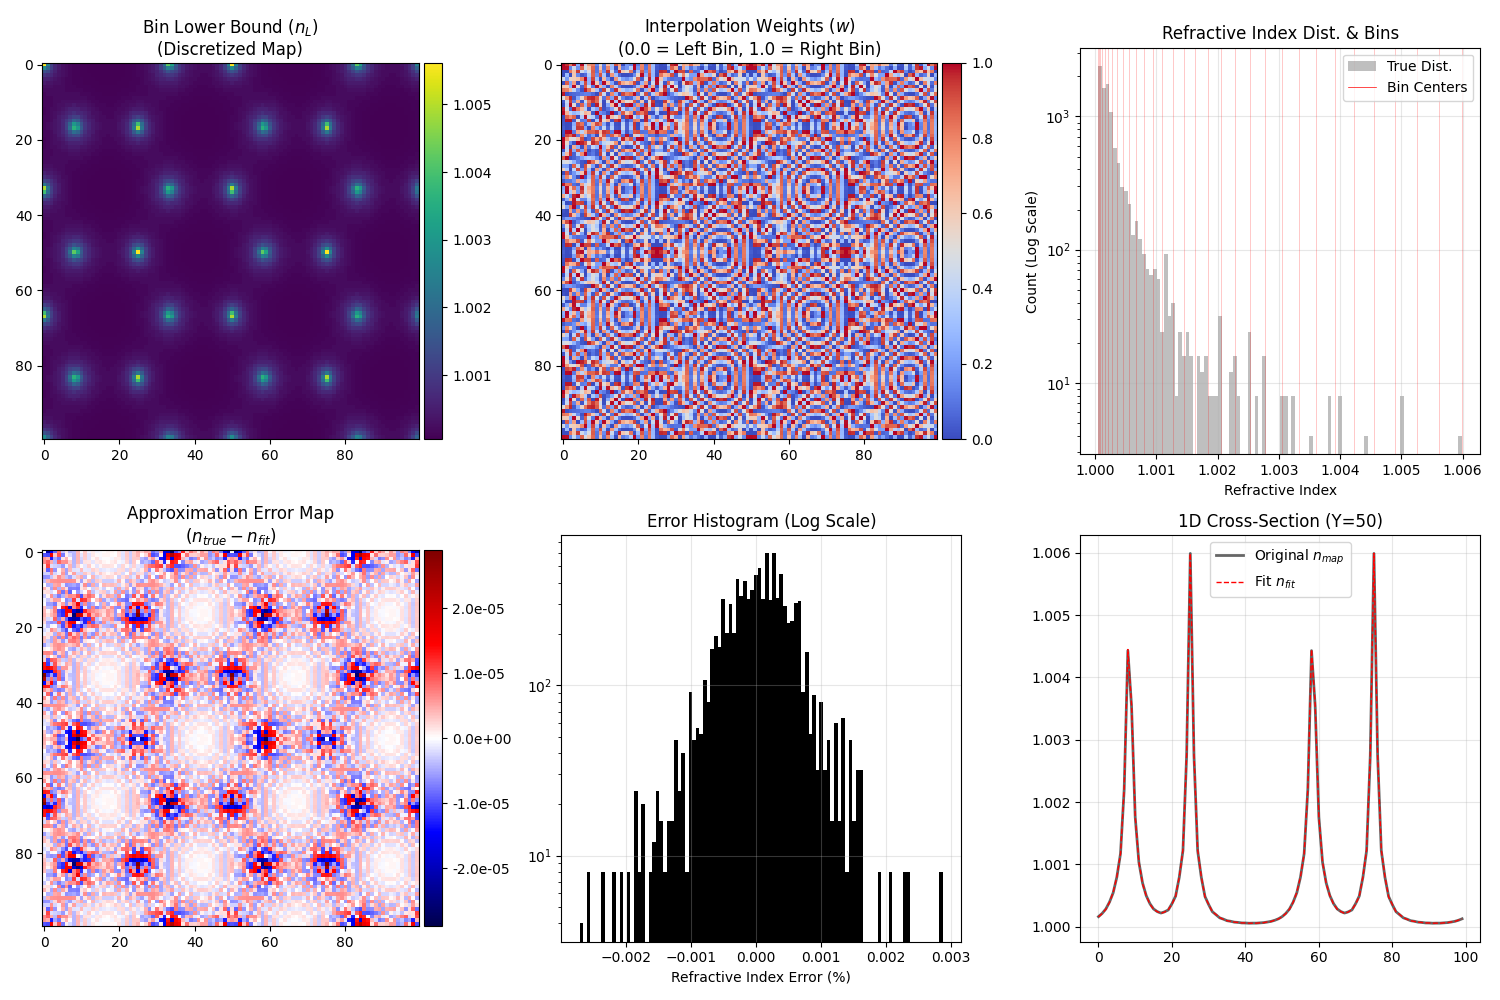

In [11]:
fig = plot_wpm_diagnostics(n_map[0], weights[0], indices[0], n_refs[0])